In [1]:
import time
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
path2data = './data/processed_data.pkl'                              # path to Data
start = time.time()                                                  # start loading time
with open(path2data, 'rb') as f:                                     # load data
    df = pickle.load(f)
end = time.time()                                                    # end loading time
print(f"Raw data loading time: {np.round(end - start, 2)} seconds")  # document loading time
memory_usage_GB = df.memory_usage(index=True).sum() * 1e-9           # memory usage
print(f"DataFrame occupies: {np.round(memory_usage_GB, 2)} GB")      # document memory usage
df['Label'] = [label.replace('�', '') for label in df['Label']]     # Fix labels names

Raw data loading time: 1.04 seconds
DataFrame occupies: 0.87 GB


Label Value Counts:
BENIGN                       2208187
PortScan                      158631
DDoS                          106086
DoS Hulk                       89156
FTP-Patator                     7935
DoS GoldenEye                   7868
SSH-Patator                     5897
DoS Slowhttptest                4514
DoS slowloris                   4417
Bot                             1912
Web Attack  Brute Force         1507
Web Attack  XSS                  652
Infiltration                      29
Web Attack  Sql Injection         21
Heartbleed                         6
Name: Label, dtype: int64


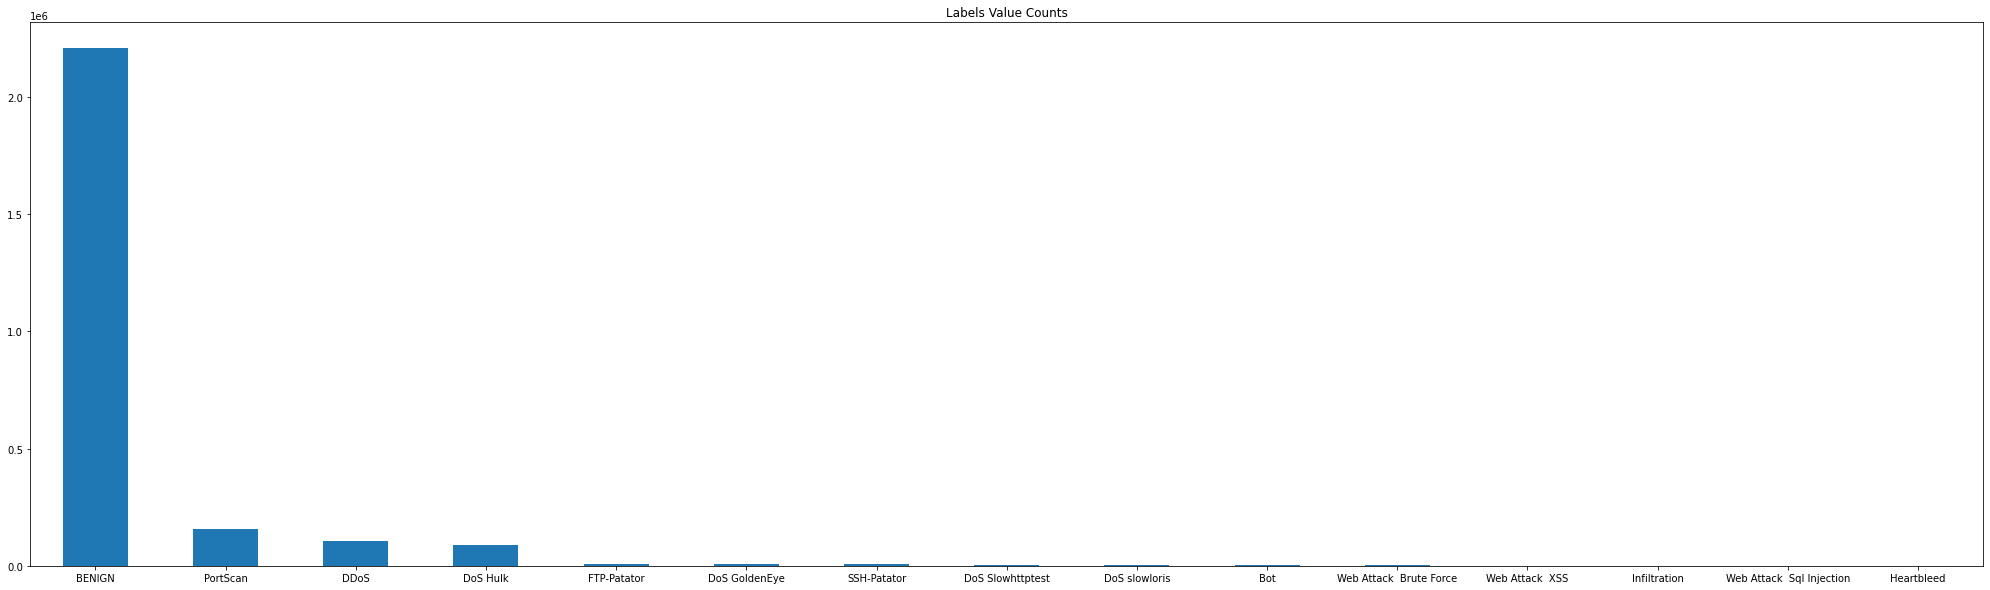

In [3]:
# labels
print('Label Value Counts:')
label_value_counts = df['Label'].value_counts()
print(label_value_counts)
# Visualization
label_value_counts.plot.bar(rot=0, figsize=(35, 10), title='Labels Value Counts')
plt.savefig('Images/Samples_Distribution.png')

Conclusion: Unbalnced data
<br>Solution:
- Sample weights

In [4]:
# # Drop BENIGN duplications
# benign = df[df['Label'] == 'BENIGN']
# attacks = df[df['Label'] != 'BENIGN']
# print(f"BENIGN Shape: {benign.shape}. Attacks Shape: {attacks.shape}")

# # drop duplication
# benign = benign.drop_duplicates()
# print(f"BENIGN Shape: {benign.shape}. Attacks Shape: {attacks.shape}")

# # concat to new dataframe
# df = pd.concat([benign, attacks]).reset_index(drop=True)
# print(f"Data Shape: {df.shape}.")

# Sample weights 
n_samples = df['Label'].value_counts()
n_samples = len(df) / n_samples
n_samples = n_samples.round()
weights_dict = {label: i for i, label in enumerate(list(n_samples.to_dict()))}

BENIGN Shape: (2208187, 42). Attacks Shape: (388631, 42)
BENIGN Shape: (2032273, 42). Attacks Shape: (388631, 42)
Data Shape: (2420904, 42).


Seperate to features and label

In [5]:
y = df['Label']
X = df.drop('Label', axis=1)
print(f"features Shape: {X.shape}. target Shape: {y.shape}")

features Shape: (2420904, 41). target Shape: (2420904,)


Post feature importence analysis, the following will be droped

In [47]:
# unimportent = ['Fwd Packet Length Mean', 'Fwd Packets/s', 'Bwd IAT Std', 
#                'Flow IAT Mean', 'Flow IAT Std', 'Fwd IAT Mean', 'Active Std',
#                'Flow Packets/s', 'Fwd Packet Length Min', 'act_data_pkt_fwd',
#                'Min Packet Length', 'URG Flag Count', 'ACK Flag Count',
#                'Bwd Packet Length Min', 'Active Max', 'Active Mean', 'Idle Std',
#                'Fwd URG Flags', 'RST Flag Count']
# X = X.drop(unimportent, axis=1)

Label Encoder

In [6]:
label2id = {label: _id for _id, label in enumerate(y.unique())}
id2label = {_id: label for _id, label in enumerate(y.unique())}
print(f"Label2ID: {label2id}")
print(f"ID2Label: {id2label}")

Label2ID: {'BENIGN': 0, 'DDoS': 1, 'PortScan': 2, 'Bot': 3, 'Infiltration': 4, 'Web Attack  Brute Force': 5, 'Web Attack  XSS': 6, 'Web Attack  Sql Injection': 7, 'FTP-Patator': 8, 'SSH-Patator': 9, 'DoS slowloris': 10, 'DoS Slowhttptest': 11, 'DoS Hulk': 12, 'DoS GoldenEye': 13, 'Heartbleed': 14}
ID2Label: {0: 'BENIGN', 1: 'DDoS', 2: 'PortScan', 3: 'Bot', 4: 'Infiltration', 5: 'Web Attack  Brute Force', 6: 'Web Attack  XSS', 7: 'Web Attack  Sql Injection', 8: 'FTP-Patator', 9: 'SSH-Patator', 10: 'DoS slowloris', 11: 'DoS Slowhttptest', 12: 'DoS Hulk', 13: 'DoS GoldenEye', 14: 'Heartbleed'}


Split to Train and Test
<br>NOTE: At the industry, data will be split to train, test, validation sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)
print(f"X Train shape: {X_train.shape}")
print(f"y Train shape: {y_train.shape}")
print(f"X Test shape: {X_test.shape}")
print(f"y Test shape: {y_test.shape}")

# Encode label
y_train_encode = np.array([label2id[label] for label in y_train])
y_test_encode = np.array([label2id[label] for label in y_test])

# sample_weights
sample_weights = np.array([weights_dict[label] for label in y_train])

X Train shape: (1210452, 41)
y Train shape: (1210452,)
X Test shape: (1210452, 41)
y Test shape: (1210452,)


Standard Scaler

In [8]:
scaler = StandardScaler()
scaler.fit(X_train.values)
X_train_scaled = scaler.transform(X_train.values)

<h1><center>ML Models</center></h1>

### Random Forest

In [55]:
rf_arg = {
    'n_estimators': 100,
    'criterion': 'gini',
    'max_depth': None, 
    'min_samples_split': 2, 
    'min_samples_leaf': 2, 
    'min_weight_fraction_leaf': 0.0, 
    'max_features': None, 
    'max_leaf_nodes': None, 
    'min_impurity_decrease': 0.0, 
    'bootstrap': True, 
    'oob_score': False, 
    'n_jobs': None, 
    'random_state': None, 
    'verbose': 0, 
    'warm_start': False, 
    'class_weight': None, 
    'ccp_alpha': 0.0, 
    'max_samples': None
}

In [56]:
# Training
start_training = time.time()
rf = RandomForestClassifier(**rf_arg)
# rf.fit(X_train_scaled, y_train, sample_weight=sample_weights)
rf.fit(X_train_scaled, y_train)
end_training = time.time()
print(f"Training run time: {end_training - start_training} seconds")

prediction_start =  time.time()
y_train_pred = rf.predict(X_train_scaled)
prediction_end =  time.time()
print(f"Prediction run time: {prediction_end - prediction_start} seconds")

# Training performence
print('Training Results:')
print(classification_report(y_train, y_train_pred, target_names=list(label2id)))


# Test performence
prediction_start =  time.time()
X_test_scaled = scaler.transform(X_test.values)
y_test_pred = rf.predict(X_test_scaled)
prediction_end =  time.time()
print(f"Prediction run time: {prediction_end - prediction_start} seconds")

print('Test Results:')
print(classification_report(y_test, y_test_pred, target_names=list(label2id)))

Training run time: 2262.0181295871735 seconds
Prediction run time: 19.09727168083191 seconds
Training Results:
                           precision    recall  f1-score   support

                   BENIGN       1.00      1.00      1.00   1016137
                     DDoS       0.99      0.99      0.99       956
                 PortScan       1.00      1.00      1.00     53043
                      Bot       1.00      1.00      1.00      3934
             Infiltration       1.00      1.00      1.00     44578
  Web Attack  Brute Force       0.99      1.00      0.99      2257
          Web Attack  XSS       1.00      0.99      1.00      2209
Web Attack  Sql Injection       1.00      1.00      1.00      3967
              FTP-Patator       1.00      1.00      1.00         3
              SSH-Patator       1.00      0.79      0.88        14
            DoS slowloris       0.99      1.00      1.00     79315
         DoS Slowhttptest       1.00      1.00      1.00      2949
                 

Feature importence

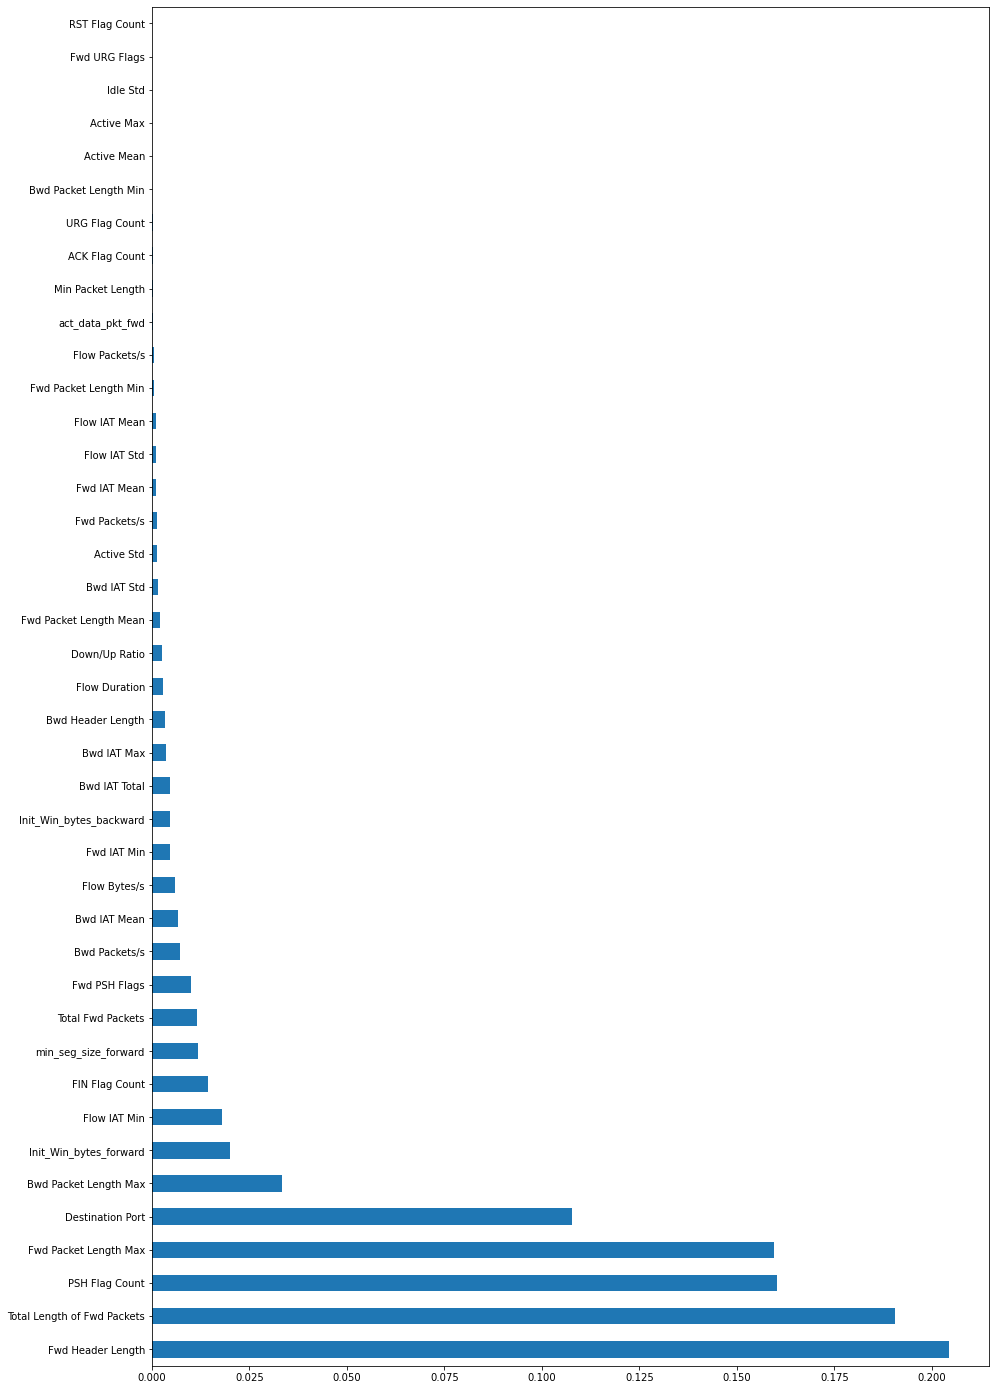

suspects features (no importence):
Index(['Bwd IAT Std', 'Active Std', 'Fwd Packets/s', 'Fwd IAT Mean',
       'Flow IAT Std', 'Flow IAT Mean', 'Fwd Packet Length Min',
       'Flow Packets/s', 'act_data_pkt_fwd', 'Min Packet Length',
       'ACK Flag Count', 'URG Flag Count', 'Bwd Packet Length Min',
       'Active Mean', 'Active Max', 'Idle Std', 'Fwd URG Flags',
       'RST Flag Count'],
      dtype='object')


In [59]:
feature_importances_ = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances_ = feature_importances_.sort_values(ascending=False)

plt.figure(figsize=(15, 25))
feature_importances_.plot.barh()
plt.savefig('Images/RF_Feature_Importence.png')
plt.show()

feature_importances_ = 100 * feature_importances_ / feature_importances_.max()
suspects_for_no_importence = feature_importances_[feature_importances_ < 1].index
print('suspects features (no importence):')
print(suspects_for_no_importence)

### XGBoost

In [9]:
xgb_arg = { 
           'learning_rate': 0.01, 
           'n_estimators': 20, 
           'subsample': 1.0, 
           'criterion': 'friedman_mse', 
           'min_samples_split': 2, 
           'min_samples_leaf': 1, 
           'min_weight_fraction_leaf': 0.0, 
           'max_depth': None, 
           'min_impurity_decrease': 0.0, 
           'init': None, 
           'random_state': None, 
           'max_features': None, 
           'verbose': 0, 
           'max_leaf_nodes': None, 
           'warm_start': False, 
           'validation_fraction': 0.1, 
           'n_iter_no_change': None, 
           'tol': 0.0001, 
           'ccp_alpha': 0.0}

In [ ]:
del df, X, y, X_train # free some space

# Training
start_training = time.time()
xgb = GradientBoostingClassifier(**xgb_arg)
xgb.fit(X_train_scaled, y_train)
end_training = time.time()
print(f"Training GradientBoostingClassifier run time: {end_training - start_training} seconds")

prediction_start =  time.time()
y_train_pred = xgb.predict(X_train_scaled)
prediction_end =  time.time()
print(f"Prediction run time: {prediction_end - prediction_start} seconds")

# Training performence
print('Training Results:')
print(classification_report(y_train, y_train_pred, target_names=list(label2id)))


# Test performence
prediction_start =  time.time()
X_test_scaled = scaler.transform(X_test.values)
y_test_pred = xgb.predict(X_test_scaled)
prediction_end =  time.time()
print(f"Prediction run time: {prediction_end - prediction_start} seconds")

print('Test Results:')
print(classification_report(y_test, y_test_pred, target_names=list(label2id)))

Feature importence

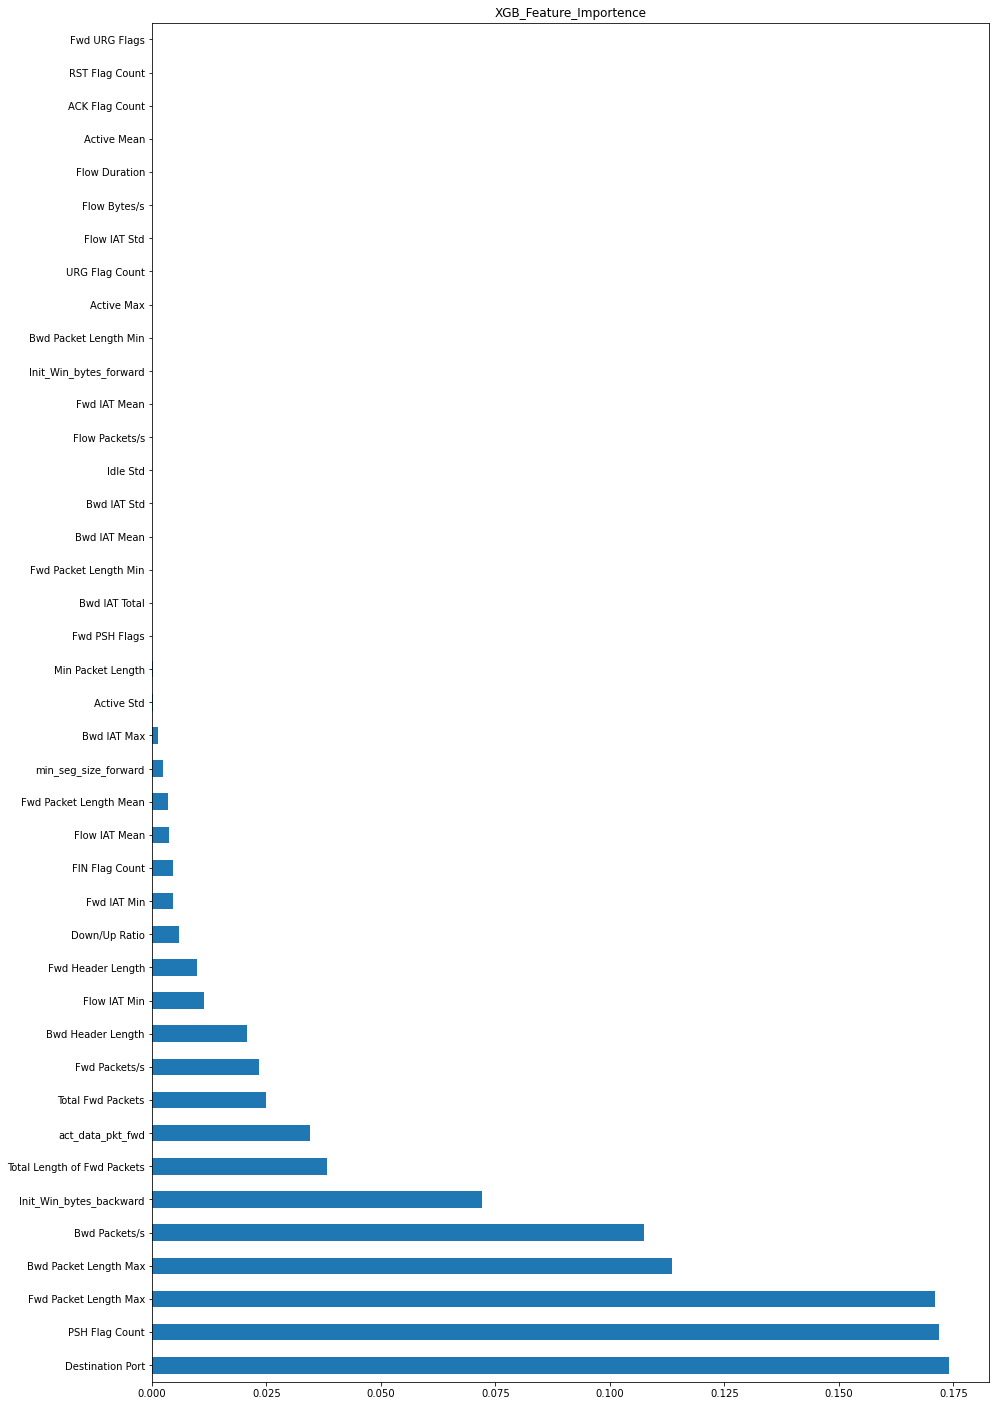

suspects features (no importence):
Index(['Bwd IAT Max', 'Active Std', 'Min Packet Length', 'Fwd PSH Flags',
       'Bwd IAT Total', 'Fwd Packet Length Min', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Idle Std', 'Flow Packets/s', 'Fwd IAT Mean', 'Init_Win_bytes_forward',
       'Bwd Packet Length Min', 'Active Max', 'URG Flag Count', 'Flow IAT Std',
       'Flow Bytes/s', 'Flow Duration', 'Active Mean', 'ACK Flag Count',
       'RST Flag Count', 'Fwd URG Flags'],
      dtype='object')


In [12]:
feature_importances_ = pd.Series(xgb.feature_importances_, index=X.columns)
feature_importances_ = feature_importances_.sort_values(ascending=False)

plt.figure(figsize=(15, 25))
feature_importances_.plot.barh()
plt.title('XGB_Feature_Importence')
plt.savefig('Images/XGB_Feature_Importence.png')
plt.show()

feature_importances_ = 100 * feature_importances_ / feature_importances_.max()
suspects_for_no_importence = feature_importances_[feature_importances_ < 1].index
print('suspects features (no importence):')
print(suspects_for_no_importence)